---
title: NICE - Nonlinear Independent Components Estimation
subtitle: Theory to Practice - A Tutorial on NICE representation.
date: 2025-10-14
bibliography:
  - references.bib
---

Nonlinear Independent Components Estimation (NICE) is a normalizing flow model proposed by
[@dinh2014nice]. It is a specially designed neural network architecture that allows computation of
exact log-likelihood, exact and efficient sampling and exact and efficient inference of latent
variables. The neural architecture is invertible and therefore provides a way of representing only
non-self-intersecting geometry. We do this by using a Pre-Aux net with the NICE architecture. In
this tutorial, we walk through the theory behind the NICE representation and how to actually use
their `geodiff` implementation in practice.

In [1]:
# Basic Imports
import matplotlib.pyplot as plt
import torch

from geodiff.aux_nets import PreAuxNet
from geodiff.nice import NICE
from geodiff.loss_functions.chamfer import ChamferLoss
from geodiff.template_architectures import ResMLP

from assets.utils import square, normalize_0_to_1


# Set the seed for reproducibility
torch.manual_seed(42)

## Theoretical Background
The NICE architecture as proposed in [@dinh2014nice] is based on the idea of stacking simple
nonlinear invertible transformations. The architecture is built such that it is easy to compute the
inverse and the determinant of the Jacobian of the transformation. Computing the inverse and the
determinant of the Jacobian is useful for log-likelihood training of generative models (of say
images) but we do not require these properties and are only interested in the architecture being
guaranteed invertible. That is, as long as we are concerned we only need a guarantee on the
transformation represented by the network being invertible we will never actually want to invert it
or compute the Jacobian of the determinant. Therefore, we only focus on the `forward` pass of the
network and do not discuss the computations of the inverse or the determinant of the Jacobian.

The NICE architecture is composed of bijective transformations with triangular Jacobians that serve
as a building block for the entire transformation `f`. In particular, it uses an additive coupling
layer as the building block defined as follows:

**Additive coupling layer:** Let $x \in \mathbb{R}^{D}$ and $I_1, I_2$ be a partition of
$\llbracket 1, D \rrbracket$ with $d = |I_1|$ and $m$ be a function defined on $\mathbb{R}^{D}$. We
can define $y = (y_{I_1}, y_{I_2})$ where:
:::{math}
:label: additive_coupling_layer
y_{I_1} = x_{I_1} \\
y_{I_2} = x_{I_2} + m(x_{I_1})
:::
where, $m$ is called the *additive coupling law*. If we choose
$I_1 = \llbracket 1, \, d \rrbracket, \ I_2 = \llbracket d+1, \, D \rrbracket$ then the Jacobian is
given by:
:::{math}
:label: NICE_Jacobian_single_layer
\frac{\partial y}{\partial x}
=
\begin{bmatrix}
I_d & 0\\
\displaystyle \frac{\partial y_{I_2}}{\partial x_{I_1}}
&
I_{D - d}
\end{bmatrix}
:::

The inverse mapping is obtained by:
:::{math}
:label: NICE_inverse
x_{I_1} = y_{I_1} \\
x_{I_2} = y_{I_2} - m(y_{I_1})
:::

Each additive coupling layer has unit Jacobian determinant as is clear from Eq.
[](#NICE_Jacobian_single_layer), i.e. is volume preserving. Therefore, their composition will
necessarily have unit Jacobian determinant too. In order to address this issue, we include a
diagonal scaling matrix $S$ as the top layer, which multiplies the $i$-th output value by
$S_{ii}$ giving $(x_i)_{i \leq D} \rightarrow (S_{ii}x_i)_{i \leq D}$.

## Implementation using `geodiff`
We now look at how `geodiff` allows us to easily use the NICE parameterization to represent shapes.

The NICE class initializer and its expected arguments are shown below:
:::{literalinclude} ../src/geodiff/nice.py
:start-at: __init__
:end-at: -> None
:::

To construct a NICE object, we need to supply:
- **Geometry Dimension** 2 for 2D and 3 for 3D.
- **Layer Count** the number of layers in the NICE architecture.
- **Coupling Net** a torch network module to be used as the additive coupling law.
- **Pre-Aux Net** parameters such as layer count, hidden dimension, activation, normalization and
    output functions.
- **Volume Preserving**, to decide whether the NICE architecture is used without the scaling layer
    at the top. This is best used with a Pre-Aux net with no parameters that preserves the area or
    volume of the closed circle or sphere.
- **Boolean Flags** for using batch normalization and residual connections with the NICE layers.

### Fitting Shapes
We will use a square as our target geometry. We then use the `ChamferLoss` to compute the geometric
difference loss between the target shape and the shape represented by our NICE parameterization.
Since the implementation is written in PyTorch we can use the autograd capabilities to compute the
gradients of the loss w.r.t. the NICE network parameters and use an optimizer to modify our
geometry.

We start by obtaining points on our shapes and normalizing them appropriately such that
$x \in [0, 1]$. This is not needed for NICE but is used to offer a comparison with the classical
shape representation methods like Hicks-Henne and CST.

In [2]:
# Get points on a square (curve to fit)
num_pts = 1000
X_square = square(num_pts)

# Normalize x values to the range [0, 1] to compare with other representation methods
X_square = normalize_0_to_1(X_square)

We now create a `NICE` object by specifying the geometry dimension, layer count, coupling network
and Pre-Aux net parameters.

In [3]:
# Create a NICE object
# First create Pre-Aux and coupling networks to pass to the NICE initializer
preaux_net = PreAuxNet(geometry_dim = 2, layer_count = 2, hidden_dim = 20)
coupling_net = ResMLP(input_dim = 1, output_dim = 1, layer_count = 2, hidden_dim = 20)
nice = NICE(
    geometry_dim = 2,
    layer_count = 4,
    preaux_net = preaux_net,
    coupling_net = coupling_net,
)

We use the `ChamferLoss` provided by `geodiff` to compute a geometric loss between the target shape
and the shape represented by the `NICE` object. PyTorch's autograd capabilities then allow us to
compute gradients of the loss w.r.t. the NICE network parameters and modify them to fit the target
shape.

In [4]:
# Train the NICE parameters to fit the square
loss_fn = ChamferLoss()

learning_rate = 0.001
epochs = 1000
print_cost_every = 200

Y_train = X_square

optimizer = torch.optim.Adam(nice.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.99)

for epoch in range(epochs):
    Y_model = nice(num_pts = num_pts)
    
    loss = loss_fn(Y_model, Y_train)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step(loss.item())

    if epoch == 0 or (epoch + 1) % print_cost_every == 0:
        num_digits = len(str(epochs))
        print(f'Epoch: [{epoch + 1:{num_digits}}/{epochs}]. Loss: {loss.item():11.6f}')

Epoch: [   1/1000]. Loss:    0.318160
Epoch: [ 200/1000]. Loss:    0.002607
Epoch: [ 400/1000]. Loss:    0.001366
Epoch: [ 600/1000]. Loss:    0.000715
Epoch: [ 800/1000]. Loss:    0.000127
Epoch: [1000/1000]. Loss:    0.000076


We can now visualize the shape represented by our `NICE` object using its `visualize` method.

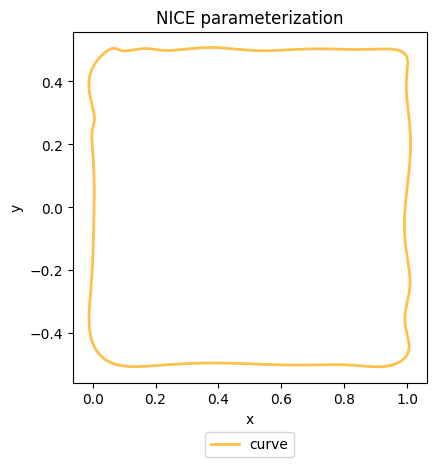

In [5]:
# Visualize the fitted NICE shape
fig, ax = nice.visualize(num_pts = num_pts)
plt.tight_layout()
plt.show()